# *Tutorial: PeakTree Dataframes*

**Author:** [Eivind Tøstesen](https://github.com/eivindtostesen)

**Tutorial goal:** *How to organize results from peak analysis in dataframes using an interface to pandas or polars.*

## Introduction

*The results of a hierarchical analysis of peaks in 1D data are contained in a `PeakTree` object.
It can always be printed (str and repr),
but a better way of viewing, organizing and further analyzing and storing the results is to export them to dataframes.*

*This notebook demonstrates the dataframe functionality provided by `peaks_in_pandas` and `peaks_in_polars`, which equip  `PeakTree` objects with new methods built on pandas/polars, and gives some example recipes.*

## Imports
Modules `peaks_in_pandas` and `peaks_in_polars` are independent and each contains all you need. They have almost identical APIs (kind of "Rosetta-stonish").

In [23]:
# In this notebook, we import both, but you can choose to import one:
import peaks_in_pandas  # requires pandas
import peaks_in_polars  # requires polars

import hierarchical_peaks as hip
import peaky_data

from matplotlib.pyplot import plot
from pandas import concat

# We also document our random seed value: 
RANDOM_SEED = "it's....."

## Example data set
Throughout the notebook, we will use the same mini example for our data set. It consists of two lists: `X` (labels) and `Y` (values). The data types are int and float, respectively.



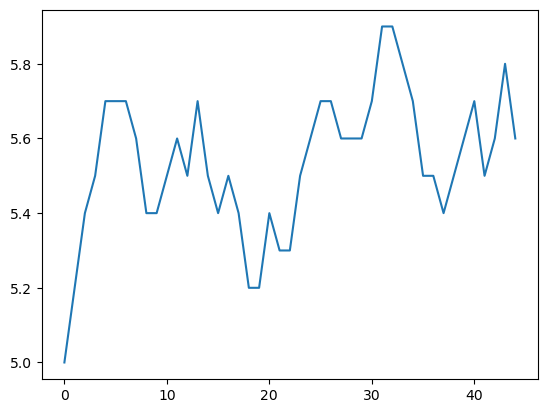

In [24]:
# Generate the data set:
X, Y = peaky_data.example_1(randomseed=RANDOM_SEED)

# Plot the data set:
plot(X, Y);

## Peak analysis
The tree of peaks in `X,Y` is analyzed by constructing `PeakTree.from_label_value_pairs(zip(X, Y))`, which also computes the location (start and end) of each peak on the x-axis.

For better appearance in dataframes, we will label each node in this tree by a capital letter. The root node we will label "Root".

All these analysis steps, that are done *before* we start using dataframes, are collected in a function that returns a `PeakTree` object:

In [25]:
def analyze_and_make_tree(X, Y):
    # make tree of peaks in the data set:
    tree1 = hip.PeakTree.from_label_value_pairs(zip(X, Y))
    # define node labeling with capital letters:
    nodemap =  dict(zip(tree1, "ABCDEFGHIJKLMNOPQRSTUVWXYZ"))
    # ..but the root node is called "Root":
    nodemap.update({tree1.root(): "Root"})
    # Apply the node labels to the tree:
    tree1.set_nodes(nodemap)
    # ..and to the tree1.location:
    tree1.location = dict((nodemap[n], t) for n, t in tree1.location.items())
    return tree1


## Basic polars functionality

Polars functionality is initialized by calling the `PeakTreePolars` class. This gives the tree object an attribute called "polars".

In [26]:
# Generate the data set:
X, Y = peaky_data.example_1(randomseed=RANDOM_SEED)
# Get the peak analysis results:
tree = analyze_and_make_tree(X, Y)

# Add polars functionality to the tree:
peaks_in_polars.PeakTreePolars(tree, location=tree.location)

print(tree.polars)


All the nodes in our `tree` can be exported to a series or a one-column dataframe by calling the methods `tree.polars.series` or `tree.polars.dataframe` with no arguments:

In [27]:
# Generate the data set:
X, Y = peaky_data.example_1(randomseed=RANDOM_SEED)
# Get the peak analysis results:
tree = analyze_and_make_tree(X, Y)
# Add polars functionality to the tree:
peaks_in_polars.PeakTreePolars(tree, location=tree.location)

# A polars series containing all tree nodes:
tree.polars.series()

node
object
Root
B
C
D
E
F
G
H
I


The `tree.polars.tree_structure` method returns a dataframe containing each tree node and its parent node, its children nodes, etcetera, showing the network structure of the tree. 

Each node is looked up in the "node" column, and other columns then show the corresponding:
- parent
- children
- top (the highest leaf node among its descendants)
- full (the largest node having the same top)

For better readability, the dataframe rows are ordered according to paths from top nodes to full nodes.

In [28]:
# Generate the data set:
X, Y = peaky_data.example_1(randomseed=RANDOM_SEED)
# Get the peak analysis results:
tree = analyze_and_make_tree(X, Y)
# Add polars functionality to the tree:
peaks_in_polars.PeakTreePolars(tree, location=tree.location)

# Dataframe with the network of peak nodes:
tree.polars.tree_structure()

top,children,node,parent,full,root
object,object,object,object,object,object
Q,[],Q,R,Root,Root
Q,['Q'],R,S,Root,Root
Q,['R'],S,P,Root,Root
Q,['S'],P,N,Root,Root
Q,"['P', 'O']",N,M,Root,Root
Q,['N'],M,T,Root,Root
Q,"['M', 'X']",T,L,Root,Root
Q,"['T', 'K']",L,B,Root,Root
Q,"['L', 'C']",B,Root,Root,Root


The `tree.polars.numeric_properties` method returns a dataframe containing each node's size, height and base height. Rows are ordered by descending height and size.

In [29]:
# Generate the data set:
X, Y = peaky_data.example_1(randomseed=RANDOM_SEED)
# Get the peak analysis results:
tree = analyze_and_make_tree(X, Y)
# Add polars functionality to the tree:
peaks_in_polars.PeakTreePolars(tree, location=tree.location)

# Dataframe with peak spans on the y-axis:
tree.polars.numeric_properties()

node,height,size,base_height
object,f64,f64,f64
Root,5.9,0.9,5.0
B,5.9,0.7,5.2
L,5.9,0.6,5.3
T,5.9,0.5,5.4
M,5.9,0.4,5.5
N,5.9,0.3,5.6
P,5.9,0.2,5.7
S,5.9,0.2,5.7
R,5.9,0.1,5.8


The `tree.polars.location_properties` method returns a dataframe containing the start and end positions on the x-axis of each peak, as well as the pair `(start, end)` called location. Both ends are inclusive because they are label-based (as opposed to slices, that are integer-based and do not include the stop value).

In [30]:
# Generate the data set:
X, Y = peaky_data.example_1(randomseed=RANDOM_SEED)
# Get the peak analysis results:
tree = analyze_and_make_tree(X, Y)
# Add polars functionality to the tree:
peaks_in_polars.PeakTreePolars(tree, location=tree.location)

# Dataframe with peak spans on the x-axis:
tree.polars.location_properties()

node,location,start,end
object,list[i64],i64,i64
Root,"[0, 44]",0,44
B,"[1, 44]",1,44
C,"[2, 17]",2,17
D,"[3, 7]",3,7
E,"[4, 6]",4,6
F,"[4, 7]",4,7
G,"[10, 14]",10,14
H,"[11, 11]",11,11
I,"[13, 13]",13,13


The internal data structure of a PeakTree object can also be exported. This can be useful for inspection or storage.

In [31]:
# Generate the data set:
X, Y = peaky_data.example_1(randomseed=RANDOM_SEED)
# Get the peak analysis results:
tree = analyze_and_make_tree(X, Y)
# Add polars functionality to the tree:
peaks_in_polars.PeakTreePolars(tree, location=tree.location)

# Export PeakTree data:
tree.polars.dump_data_attributes()


node,_data,_parent,_children,_top,_full,_root
object,f64,str,object,str,str,str
Root,5.0,null,"('B',)","""Q""","""Root""","""Root"""
B,5.2,"""Root""","('L', 'C')","""Q""","""Root""","""Root"""
C,5.4,"""B""","('D', 'G', 'J')","""E""","""C""","""Root"""
D,5.5,"""C""","('F',)","""E""","""C""","""Root"""
E,5.7,"""F""",(),"""E""","""C""","""Root"""
F,5.6,"""D""","('E',)","""E""","""C""","""Root"""
G,5.5,"""C""","('I', 'H')","""I""","""G""","""Root"""
H,5.6,"""G""",(),"""H""","""H""","""Root"""
I,5.7,"""G""",(),"""I""","""G""","""Root"""


## Basic pandas functionality
We could repeat the previous section on "Basic polars functionality", replacing "polars" with "pandas" everywhere, and it would work.

To make it less repetitive, instead, we show how to concatenate three of the dataframes into a one-view dataframe. The dataframes to be concatenated are:
- `tree.pandas.tree_structure()`
- `tree.pandas.location_properties()`
- `tree.pandas.numeric_properties()`

Rows need to be sorted in the same order, but `tree.pandas` has a `sort` method with a default order, that we can pipe each dataframe to.

In [32]:
# Generate the data set:
X, Y = peaky_data.example_1(randomseed=RANDOM_SEED)
# Get the peak analysis results:
tree = analyze_and_make_tree(X, Y)
# Add pandas functionality to the tree:
peaks_in_pandas.PeakTreePandas(tree, location=tree.location)


# Let pandas concatenate the sorted dataframes under a hierarchical index:
concat(
    {
        "Location Props": tree.pandas.location_properties().pipe(tree.pandas.sort),
        "Tree Structure": tree.pandas.tree_structure().pipe(tree.pandas.sort),
        "Numeric Props": tree.pandas.numeric_properties().pipe(tree.pandas.sort),
    },
    axis=1,
)

Location Props                     Tree Structure                          \
             node  location start end            top   children  node parent   
0            Root   [0, 44]     0  44              Q       (B,)  Root   <NA>   
1               B   [1, 44]     1  44              Q     (L, C)     B   Root   
2               C   [2, 17]     2  17              E  (D, G, J)     C      B   
3               D    [3, 7]     3   7              E       (F,)     D      C   
4               E    [4, 6]     4   6              E         ()     E      F   
5               F    [4, 7]     4   7              E       (E,)     F      D   
6               G  [10, 14]    10  14              I     (I, H)     G      C   
7               H  [11, 11]    11  11              H         ()     H      G   
8               I  [13, 13]    13  13              I         ()     I      G   
9               J  [16, 16]    16  16              J         ()     J      C   
10              K  [20, 20]    20  20              K         ()     K      L   
11              L  [20, 44]    20  44              Q     (T, K)     L      B   
12              M  [23, 36]    23  36              Q       (N,)     M      T   
13              N  [24, 34]    24  34              Q     (P, O)     N      M   
14              O  [25, 26]    25  26              O         ()     O      N   
15              P  [30, 34]    30  34              Q       (S,)     P      N   
16              Q  [31, 32]    31  32              Q         ()     Q      R   
17              R  [31, 33]    31  33              Q       (Q,)     R      S   
18              S  [31, 34]    31  34              Q       (R,)     S      P   
19              T  [23, 44]    23  44              Q     (M, X)     T      L   
20              U  [38, 40]    38  40              W       (V,)     U      X   
21              V  [39, 40]    39  40              W       (W,)     V      U   
22              W  [40, 40]    40  40              W         ()     W      V   
23              X  [38, 44]    38  44              Z     (Y, U)     X      T   
24              Y  [42, 44]    42  44              Z       (Z,)     Y      X   
25              Z  [43, 43]    43  43              Z         ()     Z      Y   

               Numeric Props                          
    full  root          node height size base_height  
0   Root  Root          Root    5.9  0.9         5.0  
1   Root  Root             B    5.9  0.7         5.2  
2      C  Root             C    5.7  0.3         5.4  
3      C  Root             D    5.7  0.2         5.5  
4      C  Root             E    5.7  0.0         5.7  
5      C  Root             F    5.7  0.1         5.6  
6      G  Root             G    5.7  0.2         5.5  
7      H  Root             H    5.6  0.0         5.6  
8      G  Root             I    5.7  0.0         5.7  
9      J  Root             J    5.5  0.0         5.5  
10     K  Root             K    5.4  0.0         5.4  
11  Root  Root             L    5.9  0.6         5.3  
12  Root  Root             M    5.9  0.4         5.5  
13  Root  Root             N    5.9  0.3         5.6  
14     O  Root             O    5.7  0.0         5.7  
15  Root  Root             P    5.9  0.2         5.7  
16  Root  Root             Q    5.9  0.0         5.9  
17  Root  Root             R    5.9  0.1         5.8  
18  Root  Root             S    5.9  0.2         5.7  
19  Root  Root             T    5.9  0.5         5.4  
20     U  Root             U    5.7  0.2         5.5  
21     U  Root             V    5.7  0.1         5.6  
22     U  Root             W    5.7  0.0         5.7  
23     X  Root             X    5.8  0.3         5.5  
24     X  Root             Y    5.8  0.2         5.6  
25     X  Root             Z    5.8  0.0         5.8

Notes:
- The same node column appear three places. Just more readable?
- The integer index on the left can be ignored, since it is not meaningful. This is true for all `tree.pandas` dataframes.

The `tree.pandas.dump_data_attributes()` was not included, but it can be used in a quick one-liner test of everything:

In [33]:
# Quick test of the imported modules:
peaks_in_pandas.PeakTreePandas(hip.PeakTree(zip(*peaky_data.example_1()))).dump_data_attributes()


,node,_data,_parent,_children,_top,_full,_root
0,0,5.0,<NA>,"(1,)",31,0,0
1,1,5.2,0,"(21, 2)",31,0,0
2,2,5.4,1,"(3, 10, 16)",4,2,0
3,3,5.5,2,"(7,)",4,2,0
4,4,5.7,7,(),4,2,0
5,7,5.6,3,"(4,)",4,2,0
6,10,5.5,2,"(13, 11)",13,10,0
7,11,5.6,10,(),11,11,0
8,13,5.7,10,(),13,10,0
9,16,5.5,2,(),16,16,0
